In [1]:
%load_ext lab_black

from copy import deepcopy
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
from PIL import ImageDraw
import json
from random import random
import numpy as np
import cv2
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import errno, os, stat, shutil
from tqdm.notebook import tqdm
from enum import Enum

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.layers import *
from keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from datetime import datetime
from focal_loss import BinaryFocalLoss

# tf.debugging.set_log_device_placement(True)
plt.rcParams["figure.figsize"] = [40, 20]
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [2]:
from datautils import *
from ArrayLoader import *
from CWDataset import *
from augmentation import *

In [3]:
original_path = Path("data/CW/original")
generated_path = Path("data/CW/generated")

In [4]:
convert_wepb(original_path)

Found 0 webp files. Converting


In [5]:
real_shape = (544, 1280, 3)
save_shape = (544 // 4, 1280 // 4, 3)
augmented_samples = 6

In [6]:
dataset = CWDataset(generated_path)

Train 1132
Test  149
Vali  149


In [7]:
def buildvgg16_model():
    vgg16_model = VGG16(weights="imagenet", include_top=True)
    for layers in (vgg16_model.layers)[:15]:
        layers.trainable = False

    headModel = vgg16_model.layers[-2].output
    headModel = Flatten(name="flatten_outer")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dense(224 * 224, activation="sigmoid")(headModel)
    headModel = Reshape((224, 224))(headModel)

    model = Model(inputs=vgg16_model.input, outputs=headModel)
    model.compile(
        loss=BinaryFocalLoss(gamma=3),  # "mean_absolute_error",
        optimizer=Adam(lr=0.0001),
        metrics=["accuracy"],
    )
    return model

In [8]:
def rescale_dataset(images, labels, step):
    res_images = []
    res_labels = []
    target_size = (224, 224)
    for i in range(images.shape[0]):
        tmp = np.zeros(images.shape[1:3])
        for label in labels[i]:
            tmp[int(label[1]) : int(label[3]), int(label[0]) : int(label[2])] = 1

        xp = 0
        while xp + target_size[0] < images[i].shape[0]:
            yp = 0
            while yp + target_size[1] < images[i].shape[1]:
                # if tmp[xp : xp + target_size[0], yp : yp + target_size[1]].sum() > 50:
                res_images.append(
                    images[i, xp : xp + target_size[0], yp : yp + target_size[1], :]
                )
                res_labels.append(
                    tmp[xp : xp + target_size[0], yp : yp + target_size[1]]
                )
                yp += step
            xp += step
    return np.asarray(res_images), np.array(res_labels)

In [9]:
img, labels = rescale_dataset(*dataset.get_train(4), 224 // 2)

# print(img.shape)
# print(labels.shape)
# # print(labels)
# plt.imshow(img[7])
# plt.show()
# plt.imshow(np.abs(labels[7]), cmap="gray")
# plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.64it/s]


In [10]:
# model = buildvgg16_model()

model = tf.keras.models.load_model("model/sliding/16-12-2020 15-02-01.h5")

In [11]:
all_img, all_labels = dataset.get_train(5000)
batch_size = 150
for i in range(all_img.shape[0] // batch_size):
    images, labels = rescale_dataset(
        all_img[i * batch_size : (i + 1) * batch_size],
        all_labels[i * batch_size : (i + 1) * batch_size],
        224,
    )

    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    ]
    with tf.device("/GPU:0"):
        model.fit(
            images, labels, epochs=50, validation_split=0.1, callbacks=my_callbacks
        )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:10<00:00, 113.14it/s]


Epoch 1/50
 1/43 [..............................] - ETA: 0s - loss: 0.0494 - accuracy: 0.2366WARNING:tensorflow:From C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
43/43 [==============================] - 9s 200ms/step - loss: 0.0316 - accuracy: 0.0997 - val_loss: 0.0408 - val_accuracy: 0.0996
Epoch 2/50
43/43 [==============================] - 7s 160ms/step - loss: 0.0161 - accuracy: 0.1048 - val_loss: 0.0364 - val_accuracy: 0.2096
Epoch 3/50
43/43 [==============================] - 7s 159ms/step - loss: 0.0112 - accuracy: 0.0845 - val_loss: 0.0530 - val_accuracy: 0.2827
Epoch 4/50
43/43 [==============================] - 7s 160ms/step - loss: 0.0096 - accuracy: 0.1169 - val_loss: 0.0505 - val_accuracy: 0.1512
Epoch 5/50
43/43 [==============================] 

In [12]:
dt_string = datetime.now().strftime("model/sliding/%d-%m-%Y %H-%M-%S.h5")
print("saving as " + dt_string)
model.save(dt_string)

saving as model/sliding/16-12-2020 15-13-47.h5


In [13]:
# print("Test")

# images, labels = rescale_dataset(
#     all_img[(all_img.shape[0] // batch_size) * batch_size : ],
#     all_labels[(all_img.shape[0] // batch_size) * batch_size : ],
#     224,
# )

# model.test_on_batch(images, labels)

In [44]:
def predict_image(image, show=True):
    prediction_map = np.zeros(image.shape[:2], dtype=float)
    count_map = np.zeros(image.shape[:2], dtype=float)

    target_size = (224, 224)
    xp = 0
    step = 100  # 224 // 2
    while xp + target_size[0] <= image.shape[0]:
        yp = 0
        while yp + target_size[1] <= image.shape[1]:
            predict = model.predict(
                np.asarray(
                    (image[xp : xp + target_size[0], yp : yp + target_size[1], :],)
                )
            )
            prediction_map[
                xp : xp + target_size[0], yp : yp + target_size[1]
            ] += predict[0]

            count_map[xp : xp + target_size[0], yp : yp + target_size[1]] += 1

            yp += step
        xp += step
    count_map[count_map == 0] = 1
    prediction_map /= count_map
    if show:
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.subplot(1, 3, 2)
        plt.imshow(prediction_map, cmap="gray")
        cpy = deepcopy(prediction_map)
        cpy[prediction_map < 0.7] = 0
        cpy[prediction_map >= 0.7] = 1

        plt.subplot(1, 3, 3)
        plt.imshow(cpy, cmap="gray")

        plt.show()
    return prediction_map


#     prediction_map[prediction_map >= threshold] = 1
#     prediction_map[prediction_map <= threshold] = 0
#     plt.subplot(1, 3, 3)
#     plt.imshow(prediction_map, cmap="gray")
#     plt.show()

In [45]:
data = dataset.get_test(200)
for i in range(0):
    predict_image(data[0][i + 50])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:01<00:00, 112.36it/s]


In [50]:
from random import randint


def test_on_data(arrays, labels, count, threshold):
    Y_pred = []
    Y_real = []
    idx = []
    for i in range(count):
        idx.append(randint(0, arrays.shape[0] - 1))
        Y_pred.append(predict_image(arrays[idx[-1]], True))
        Y_real.append(labels[idx[-1]])

    for iou in range(1, 11):
        Y_calc = []
        for i in range(count):
            Y_calc.append(probs_to_labels(Y_pred[i], threshold, 1))

        print(iou / 10.0, accuracy(Y_real, Y_calc, iou / 10.0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.15it/s]


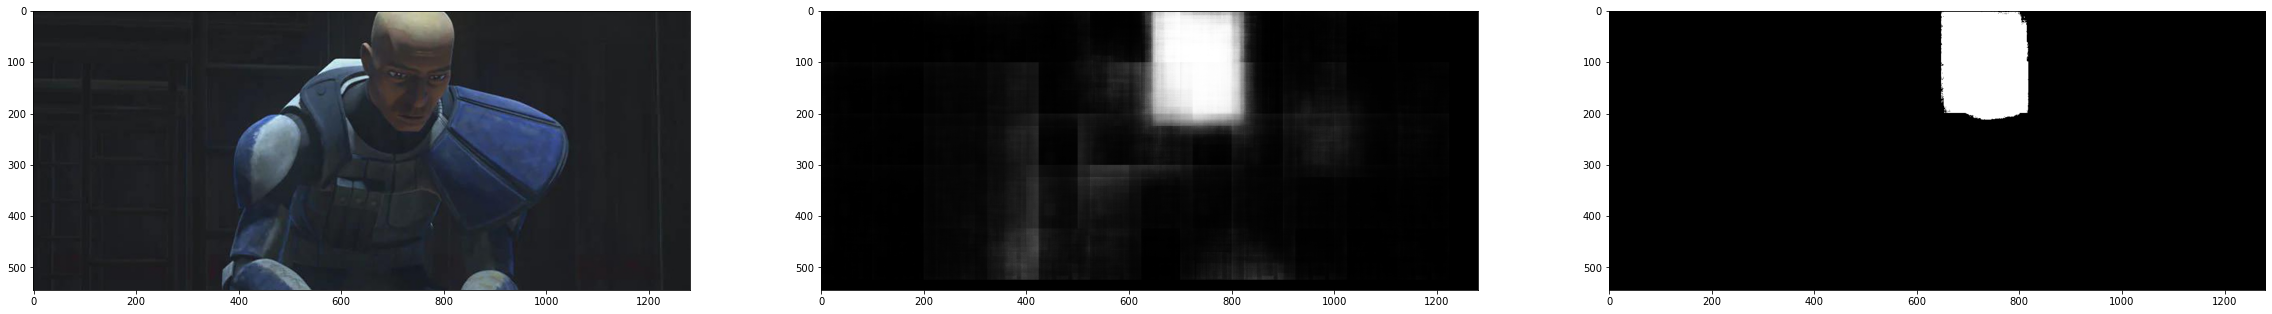

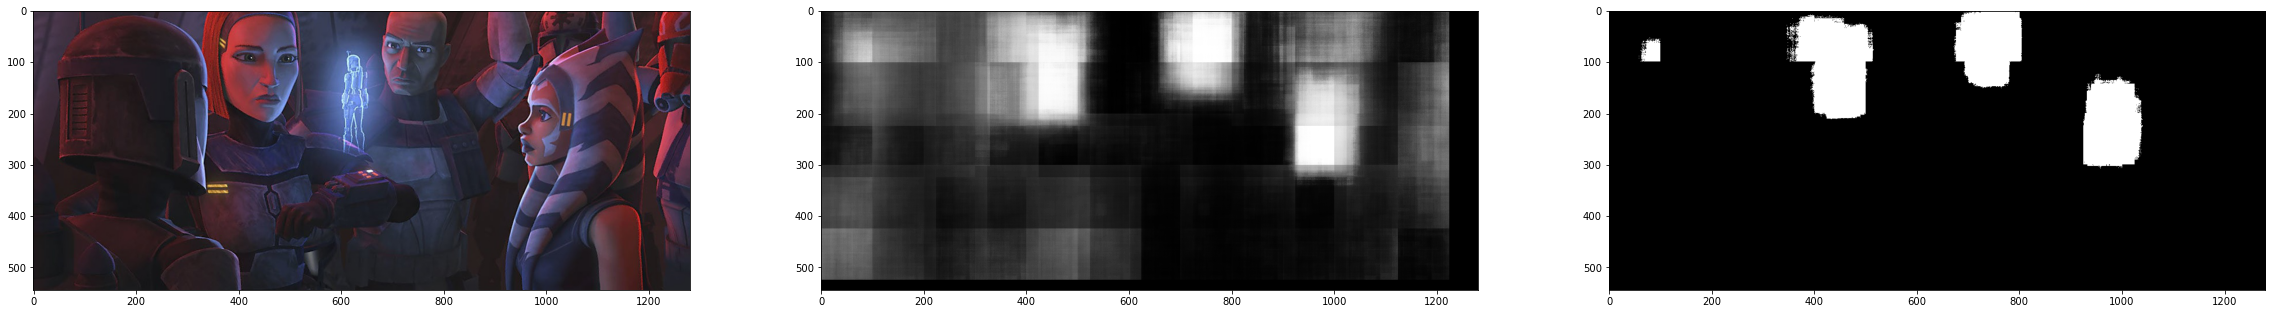

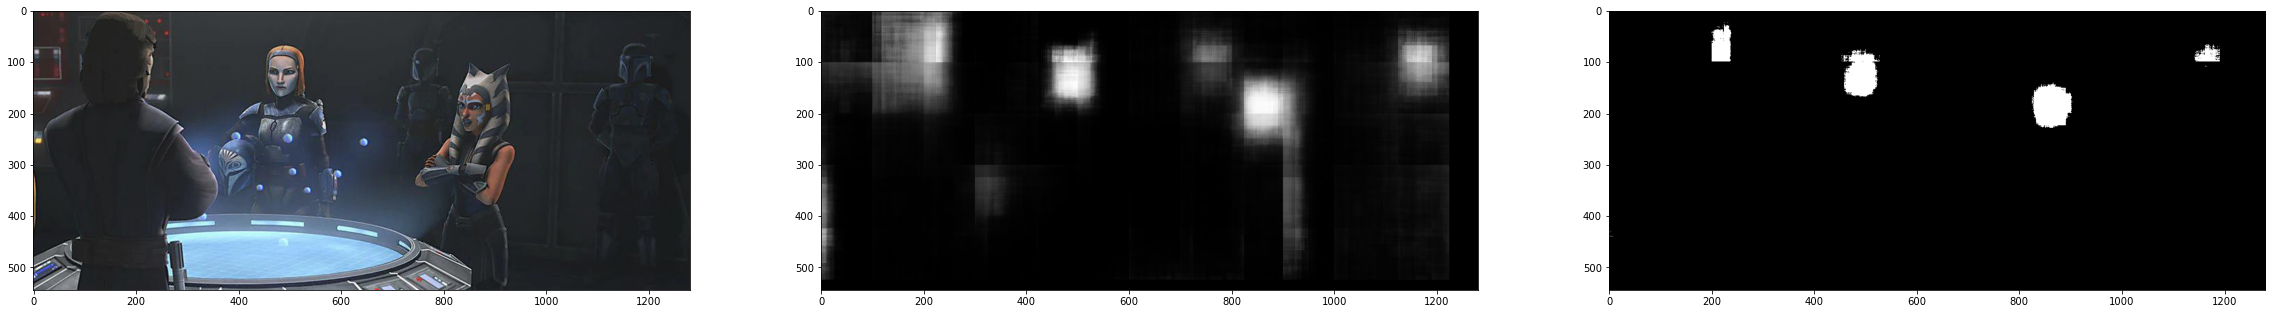

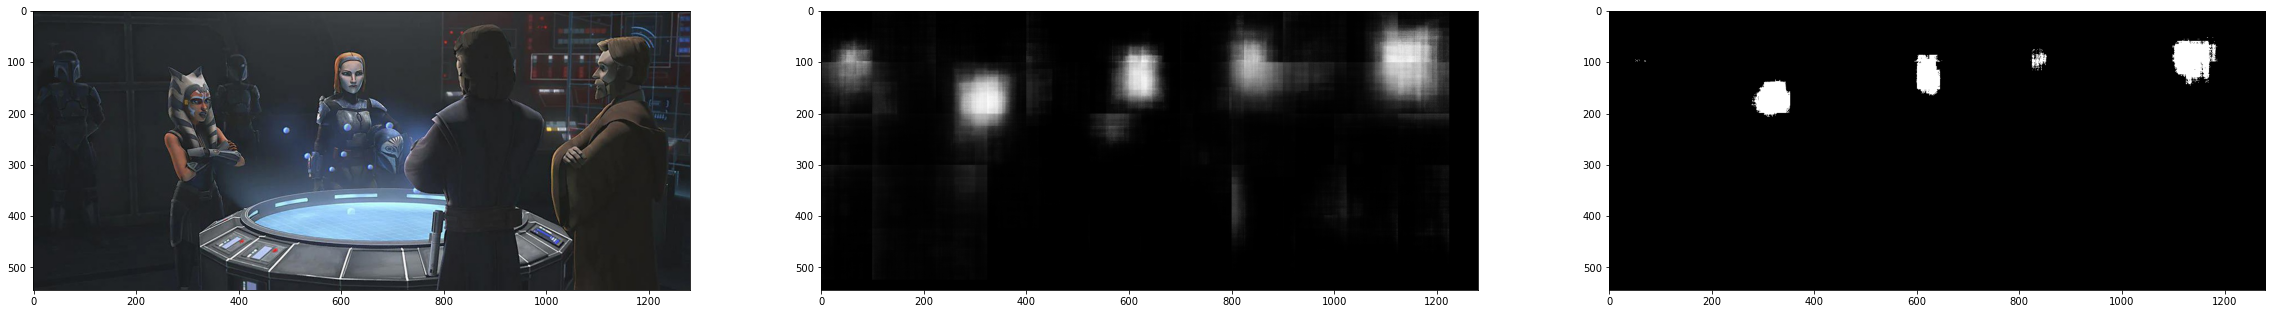

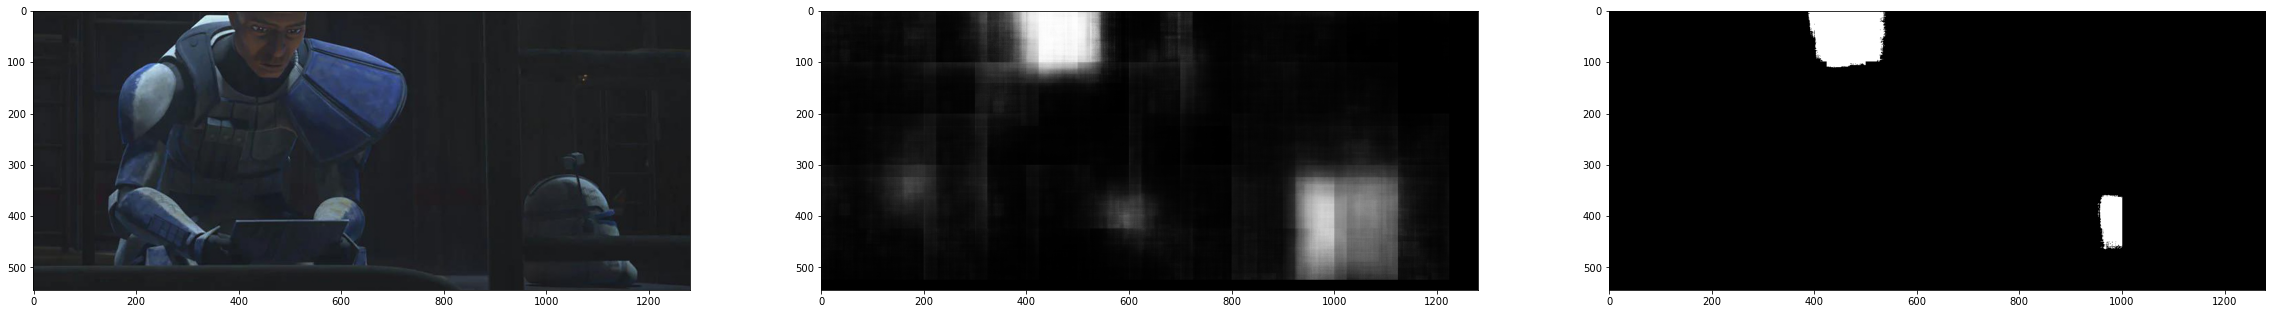

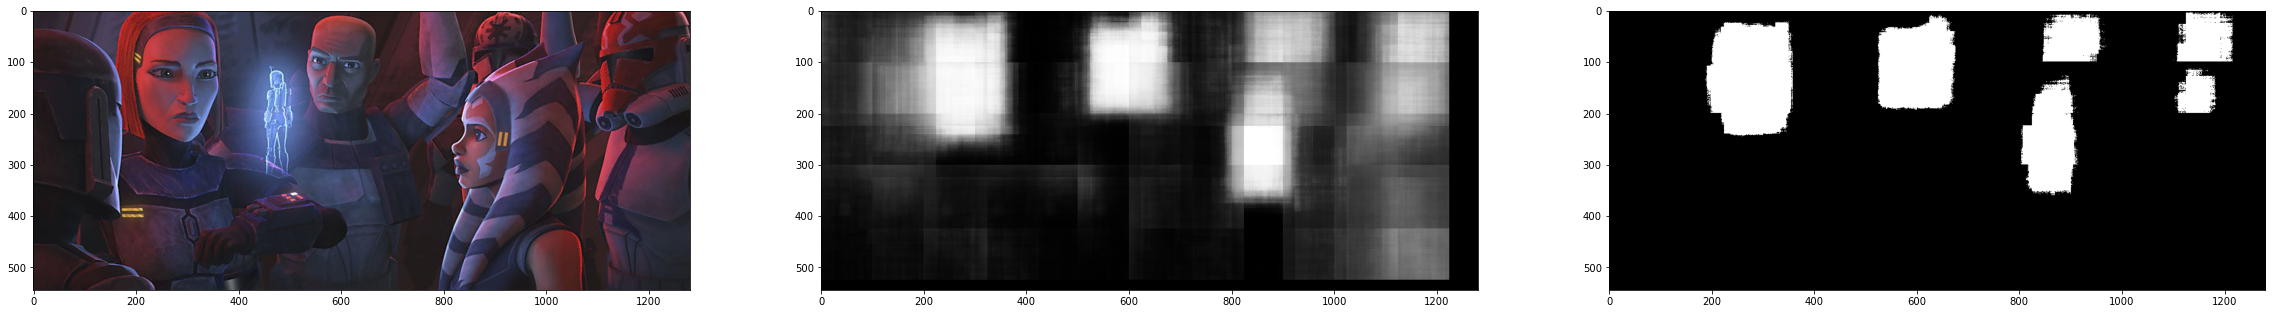

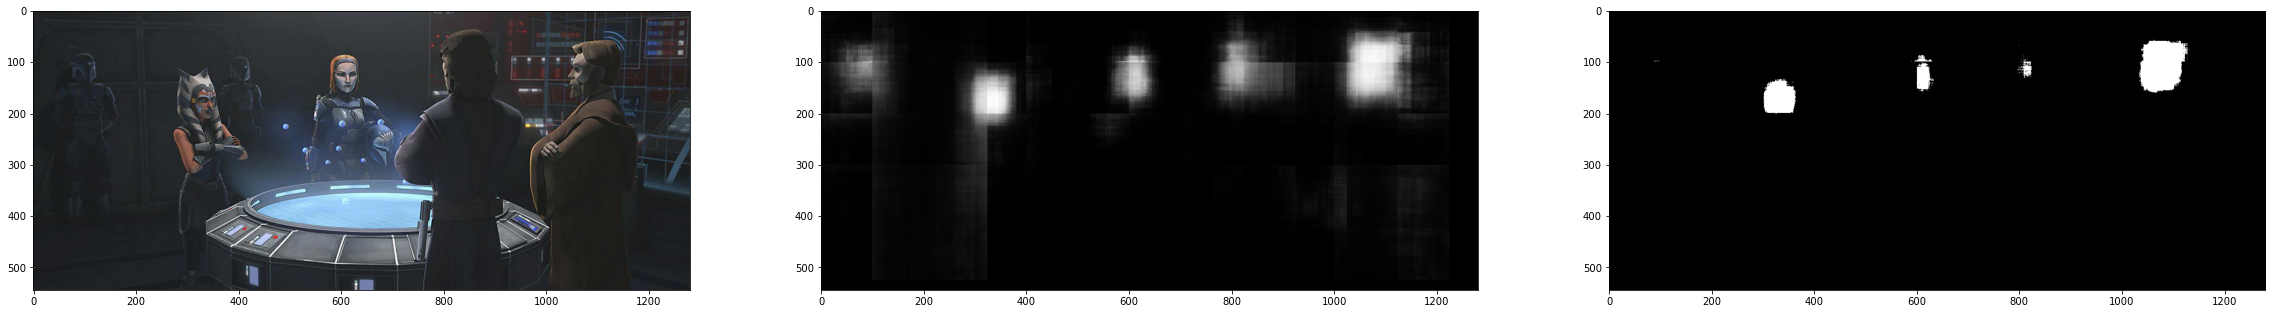

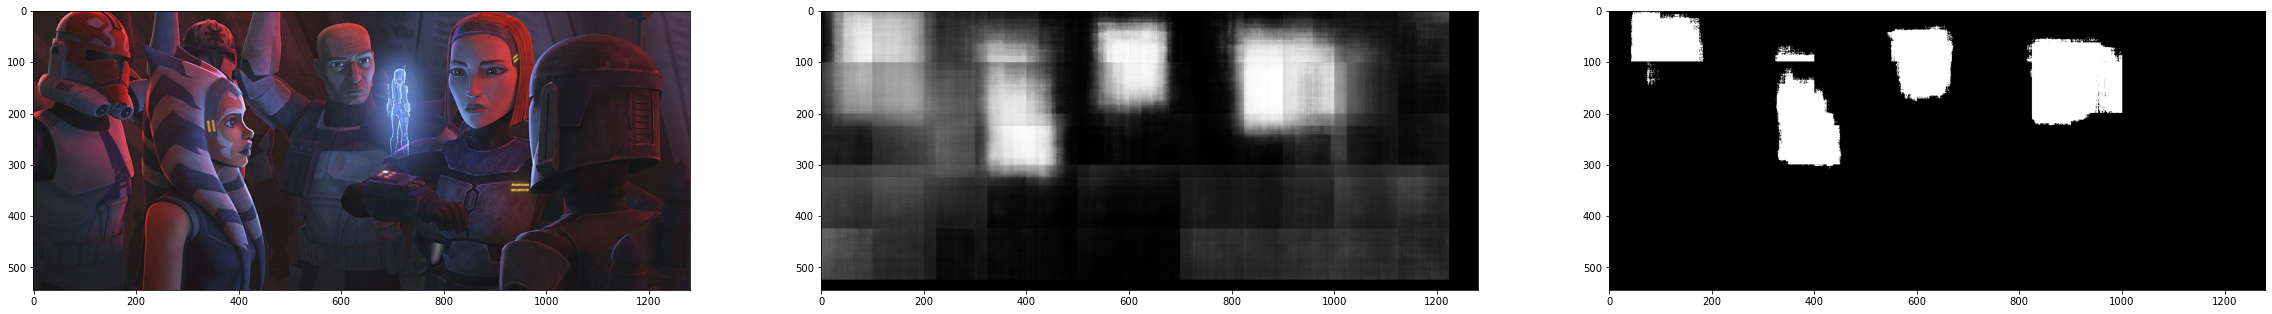

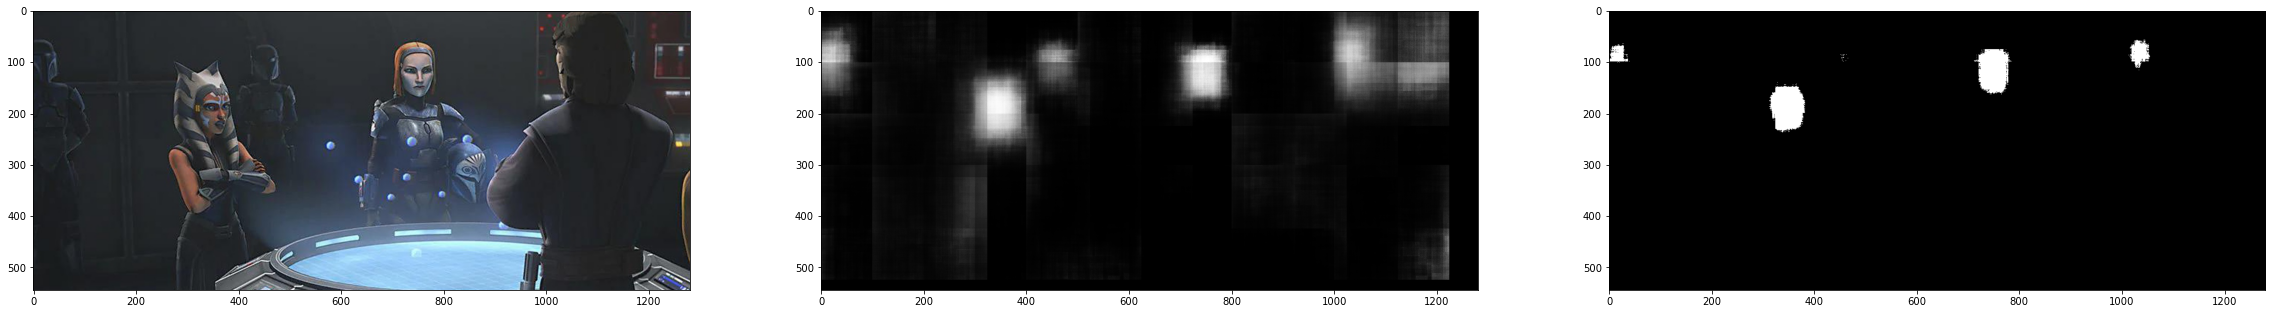

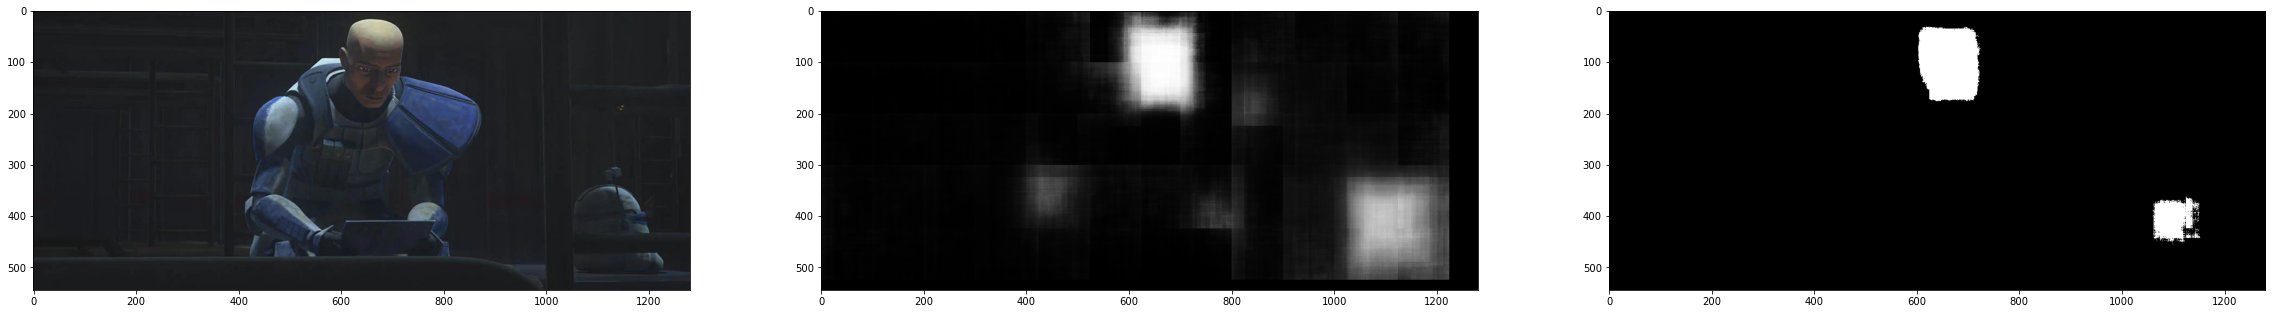

0.1 0.7948717948717948
0.2 0.7435897435897436
0.3 0.717948717948718
0.4 0.717948717948718
0.5 0.6410256410256411
0.6 0.5128205128205128
0.7 0.4358974358974359
0.8 0.2564102564102564
0.9 0.02564102564102564
1.0 0.0


In [51]:
test_on_data(*dataset.get_train(50), 10, 0.6)

In [ ]:
test_on_data(*dataset.get_test(20), 0.7)

In [ ]:
test_on_data(*dataset.get_train(20), 0.7)